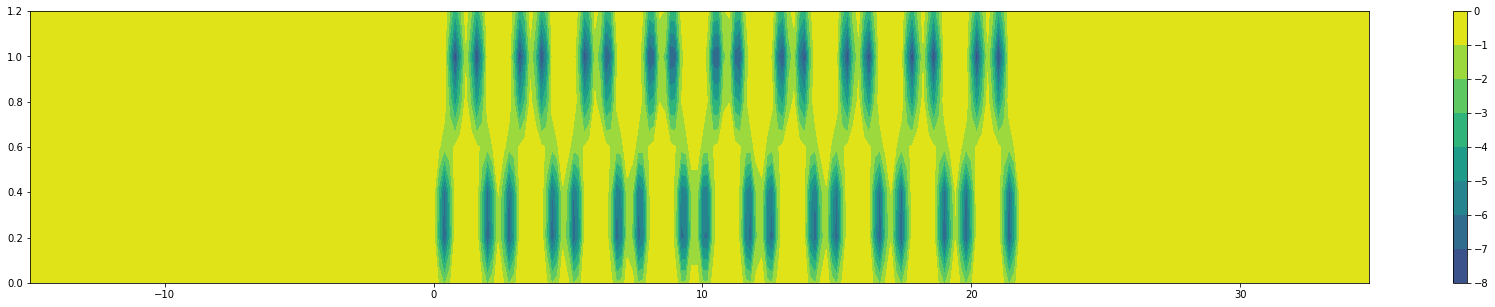

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# PRL 119, 253904 (2017)
#https://doi.org/10.1103/PhysRevLett.119.253904

a = 1.4 #lattice constant
b = a/np.sqrt(3)
uc_pillars = [(0,0),       (0.5*b, 0.5*np.sqrt(3)*b), 
             (1.5*b,0.5*np.sqrt(3)*b), (2*b,0)] 
             #4 pillars' coordinates in the rectangular unit cell
cell_width = np.sqrt(3)*a
cell_height = a

def principaly(y):
    return np.abs(cell_height*(y/cell_height-np.floor(y/cell_height)))

def pillar(coord,pillarindex):
    x,y = coord
    i,j = pillarindex
    ym = j*cell_height + uc_pillars[i%4][1]             + a/np.sqrt(24)
    xm = np.floor(i/4)*cell_width + uc_pillars[i%4][0]  + a/np.sqrt(12)
    
    p=8
    d=.25
    return -p*np.exp(-((x-xm)**2+(y-ym)**2)/d**2)

def R(x,y):
    total = 0
    y = principaly(y)
    for i in np.arange(0,len(uc_pillars)*9):
        total += pillar( (x,y) , pillarindex=(i,0) )
    return total

vR = np.vectorize(R)
x_ = np.arange(-15, 35, 0.2)
y_ = np.arange(0, cell_height, 0.2)
x_, y_ = np.meshgrid(x_, y_)

r_ = vR(x_,y_)

plt.figure(figsize=(30,5))
h = plt.contourf(x_, y_, r_)

plt.colorbar()
plt.clim(-10,0)
plt.show()

# Eigenvalue equation

Removing extra terms in Eq 2 of [PRL 119, 253904 (2017)](https://doi.org/10.1103/PhysRevLett.119.253904) gives
$$
\frac{1}{2}\left(\partial_x^2+\partial_y^2+2ik\partial_y-k^2\right)u-\mathcal{R}u+\varepsilon u=0,
$$ where the $\pm$ subscript in eq2 is now redundant.
Using a 2D spatial Fourier transform e.g.:
$$
u=\iint \frac{dq\,dk}{(2\pi)^2}\,e^{iqx}e^{iky}\,\tilde{u}(q,k),
$$ and using the substitutions:
$$
\partial_x^2\xrightarrow{}{-q^2\tilde{u}},\quad \\
\partial_y\xrightarrow{}{ik\tilde{u}},
$$ we get a FT'd equation in momentum space:
$$
\frac{1}{2}\left(q^2+4k^2\right)\tilde{u}+\tilde{\mathcal{R}}\ast \tilde{u}=\varepsilon \tilde{u},
$$ where $\ast$ is convolution operation, and $\tilde{u}$ & $\tilde{\mathcal{R}}$ are matrices of size of the supercell.



(7, 250)
(7, 250)


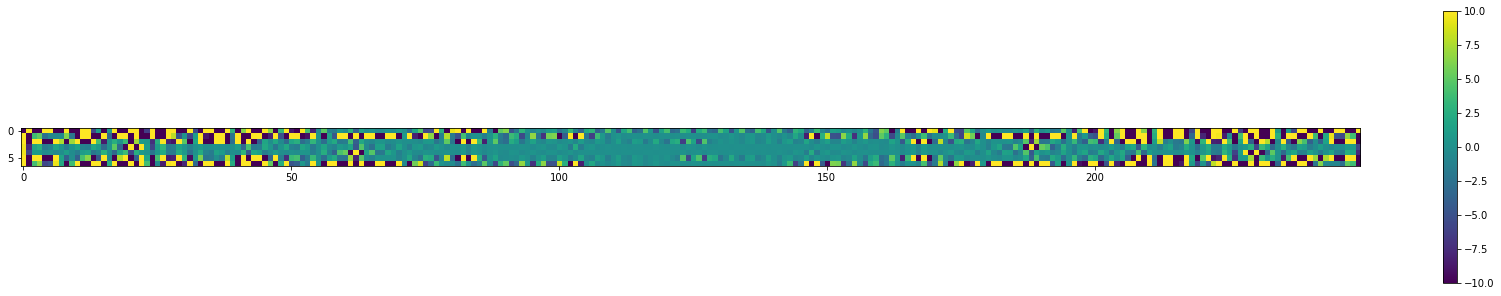

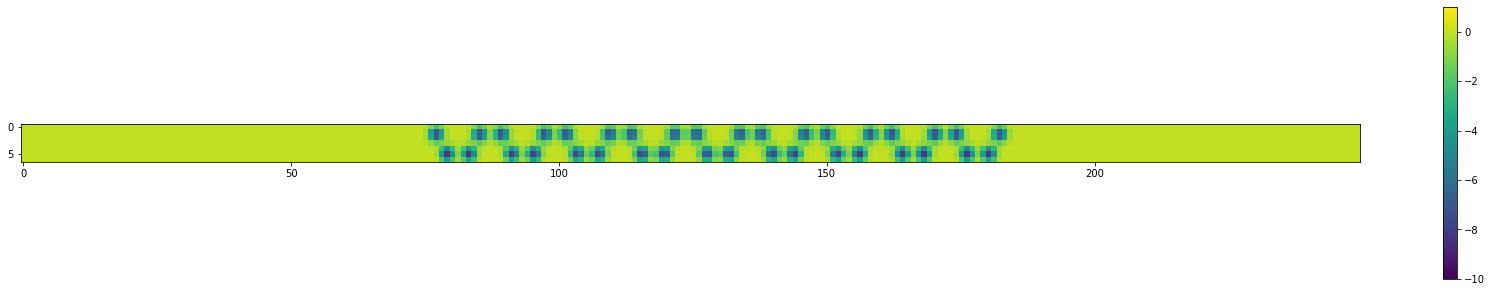

In [6]:
from scipy.fft import *

r_tilde = fft2(r_)

print(r_.shape)
print(r_tilde.shape)

plt.figure(figsize=(30,5))
h = plt.imshow(np.real((r_tilde)))
plt.colorbar()
plt.clim(-10,10)

r_recovered = ifft2(r_tilde)

plt.figure(figsize=(30,5))
h = plt.imshow(np.real((r_recovered)))
plt.colorbar()
plt.clim(-10,1)

# Convolution

The difficult part is to find the matrix representation of $\tilde{\mathcal{R}}\ast$. From [here](http://www.songho.ca/dsp/convolution/convolution2d_example.html), a discrete 2D convolution is the following operation:
$$
y_{mn}=\,x_{mn}\ast h_{mn}=\,\sum_{j,i} \,h_{m-i,n-j}\cdot x_{ij}.
$$
So a convolution is sum of hadamard product of matrices over all possible relative matrix positions of $h$ and $x$. Below we have a function `toemat` to convert $\tilde{\mathcal{R}}\ast$ to a matrix multiplication operation inteded to be applicable on the flattened version of $\tilde{u}$.


In [128]:
# convolution matrix test
from scipy import signal as sg
import numpy as np
x = np.random.uniform(-1, 1, (3,4)) + 1.j * np.random.uniform(-1, 1, (3,4)) # same as the u eigenvector above

h = np.random.uniform(-1, 1, (3,4)) + 1.j * np.random.uniform(-1, 1, (3,4)) # same as R(q,k)
hstarx = sg.convolve2d(h,x)
# print(hstarx)

def toemat(h,x): # x is matrix form, returns toeplitz for use with vectorised x, along with intended shape of output
    # wording: convolution = toeplitz * x.flatten()
    xrows,xcols = x.shape
    hrows,hcols = h.shape
    convrows = xrows+hrows-1
    convcols = xcols+hcols-1
    toerows = convrows*convcols # because the toe matrix returns flattened convolution
    toecols = xrows*xcols # because the toe(plitz) matrix acts on flattened x
    toeplitz = np.zeros((toerows,toecols)) + 0j #  toeplitz which will act on flattened x and gives convolution
    #write the toeplitz matrix:
    for i in np.arange(0,toerows): # each i is one hadamard product
        #coordinates of hadamard product (in other words the coordinates in convolution matrix. Also the across and high by which h and x are slid against each other):
        had_i = np.floor(i/convcols)
        had_j = i % convcols
        
        x_js = np.arange(np.max([0,had_j-hcols+1]), np.min([xcols,had_j+1]),dtype=int)
        h_js = np.arange(np.max([0,hcols-had_j-1]),np.min([hcols,hcols-had_j+xcols-1]),dtype=int)
        x_is = np.arange(np.max([0,had_i-hrows+1]), np.min([xrows,had_i+1]),dtype=int)
        h_is = np.arange(np.max([0,hrows-had_i-1]),np.min([hrows,hrows-had_i+xrows-1]),dtype=int)
        
        # print(x_js,h_js)
        
        for (x_j,h_j) in zip(x_js,h_js):
            for (x_i,h_i) in zip(x_is,h_is):
                toeplitz[i,x_i*xcols+x_j] = h[hrows-1-h_i][hcols-1-h_j]        
    return (toeplitz,(convrows,convcols))

#Test toemat method:
toeplitz,convsize = toemat(h,x)
hstarx_from_mat = np.matmul(toeplitz,x.flatten()).reshape(convsize)
# print(hstarx_from_mat)

print(np.linalg.norm(hstarx-hstarx_from_mat))
u,s,vh = np.linalg.svd(hstarx)
print(s)

1.4809621942062479e-15
[7.07532939 3.29626855 2.04298165 1.87543989 0.6067975 ]


In [97]:
import numpy as np

xrows = 3
xcols = 4
hrows = 3
hcols = 4

had_i = 0
had_j = 2

x_js = np.arange(np.max([0,had_j-hcols+1]), np.min([xcols,had_j+1]))
h_js = np.arange(np.max([0,hcols-had_j-1]),np.min([hcols,hcols-had_j+xcols-1]))
x_is = np.arange(np.max([0,had_i-hrows+1]), np.min([xrows,had_i+1]))
h_is = np.arange(np.max([0,hrows-had_i-1]),np.min([hrows,hrows-had_i+1]))
print(hcols-had_j-1)
print("h: ",h_js, len(h_js))
print("x: ",x_js, len(x_js))

# print("h rows: ",h_is, len(h_is))
# print("x rows: ",x_is, len(x_is))

for (x_j,h_j) in zip(x_js,h_js):
    print(x_j,h_j)

1
h:  [1 2 3] 3
x:  [0 1 2] 3
0 1
1 2
2 3
